### 캐글 데이터 분석 실습  
#### 런던 자전거 수요 예측 

*이 데이터 실습은 DIP 대구 빅데이터활용센터의 유튜브 영상 '캐글로 시작하는 데이터 분석'을 참고하였습니다. 데이터 분석의 설명 후 코드 전체를 첨부하였습니다.*

# London Bike Sharing 수요 예측 데이터 분석 (Kaggle)

이번 글에서는 Kaggle의 **London Bike Sharing Dataset**을 활용하여  
시간대별 자전거 대여 수요(`cnt`)를 예측하는 회귀 문제를 분석한 과정을 정리한다.

본 분석은 단순히 모델 하나를 학습하는 데서 끝나는 것이 아니라,

- 탐색적 데이터 분석(EDA)
- 데이터 전처리 및 피처 엔지니어링
- 이상치 처리
- 머신러닝 · 딥러닝 모델링
- 성능 비교 및 시각화

까지 **데이터 분석의 전체 흐름을 실습 형태로 경험하는 것**을 목표로 진행했다.

---

## 1. 데이터 로드 및 구조 확인

사용한 데이터는 Kaggle의 `london_merged.csv`로,  
`timestamp` 컬럼을 날짜형(datetime)으로 변환하여 불러왔다.

- 데이터 크기: **(17,414, 10)**
- 주요 변수 구성
  - `timestamp` : 시간 정보
  - `cnt` : 자전거 대여 수요 (타깃 변수)
  - `t1`, `t2` : 실제 온도 / 체감 온도
  - `hum` : 습도
  - `wind_speed` : 풍속
  - `weather_code` : 날씨 범주
  - `is_holiday`, `is_weekend`
  - `season`

결측치는 `isna()`와 `missingno` 시각화를 통해 확인했으며,  
대부분의 컬럼에서 **결측치가 거의 없는 비교적 정제된 데이터**임을 확인했다.

---

## 2. 시간 변수 확장 (Feature Engineering)

시계열 데이터 분석에서 핵심은  
시간 정보를 모델이 학습 가능한 형태로 변환하는 것이다.

이를 위해 `timestamp` 컬럼에서 다음과 같은 파생 변수를 생성했다.

- `year`
- `month`
- `dayofweek`
- `hour`

`.dt` 접근자를 활용해 연·월·요일·시간 정보를 분리했으며,  
이 과정을 통해 데이터는 **10개 컬럼에서 14개 컬럼으로 확장**되었다.

---

## 3. 탐색적 데이터 분석 (EDA)

모델링에 앞서 자전거 수요(`cnt`)가  
시간에 따라 어떤 패턴을 가지는지 시각적으로 확인했다.

### 3.1 연도 및 월별 수요 분포

- `year` vs `cnt`
- `month` vs `cnt`

연도 및 계절 변화에 따라 수요 분포가 달라지는 경향을 확인할 수 있었다.

### 3.2 요일 및 시간대별 수요 패턴

- `dayofweek` vs `cnt`
  - 전반적으로 **주말보다 평일 수요가 더 높은 경향**
- `hour` vs `cnt`
  - **출퇴근 시간대에 수요가 뚜렷하게 증가**

이는 자전거 대여가  
레저 목적보다는 **일상적인 이동 수단**으로 활용되고 있음을 보여준다.

### 3.3 반복 시각화를 위한 함수화

시간·요일·월 등 다양한 변수에 대해  
평균 수요를 빠르게 비교하기 위해 시각화 함수를 정의해 사용했다.  
이를 통해 EDA 과정의 반복 작업을 줄이고 패턴 분석에 집중할 수 있었다.

---

## 4. 이상치 처리: 시간대별 분포 기준

이번 분석에서는 전체 분포 기준이 아닌,  
**시간대(hour)별 조건부 분포를 기준으로 이상치를 제거**했다.

시간대마다 수요의 평균과 분산이 다르다는 점을 고려한 접근이다.

### 이상치 기준

- 각 `hour` 그룹에서
- `cnt`가 `평균 ± 3 × 표준편차` 범위를 벗어나는 경우 이상치로 판단

### 처리 결과

- 이상치 제거 전: **(17,414, 14)**
- 이상치 제거 후: **(17,265, 14)**

시간대 특성을 반영한 이상치 제거를 통해  
모델 학습 시 극단값의 영향을 줄일 수 있었다.

---

## 5. 범주형 변수 처리 및 더미 인코딩

머신러닝과 딥러닝 모델 학습을 위해  
범주형 변수를 명시적으로 처리했다.

- `weather_code`, `season` → `category` 타입 변환
- `pd.get_dummies()`를 활용해 원-핫 인코딩 적용
- `year`, `month`, `hour` 역시 범주형으로 처리

- 타깃 변수: `cnt`
- 입력 변수: `timestamp`, `cnt`를 제외한 나머지 컬럼

---

## 6. 시계열 데이터 분리 (Train / Test)

훈련 데이터와 테스트 데이터 분리는 `train_test_split`을 사용했으며,  
**shuffle=False** 옵션을 적용했다.

### 적용 이유

시계열 데이터에서 무작위 셔플을 적용하면  
미래 데이터가 학습 데이터에 포함되는  
**데이터 누수(data leakage)**가 발생할 수 있기 때문이다.

### 분리 결과

- `x_train`: **(12,085, 57)**
- `x_test`: **(5,180, 57)**

---

## 7. 딥러닝 모델 (DNN)

### 모델 구조

- 입력 차원: 57
- Dense Layer 구성  
  - 160 → 60 → 20 → 1
- 활성화 함수  
  - Hidden layer: ReLU  
  - Output layer: Linear
- Loss Function: MAE
- Optimizer: Adam
- EarlyStopping 적용

학습 과정에서 `loss`와 `val_loss`를 시각화하여  
모델의 수렴 상태와 과적합 여부를 함께 확인했다.

### 성능 결과

- **DNN RMSE ≈ 258.42**

이번 실습에서는 딥러닝 모델이 가장 우수한 성능을 보였다.

---

## 8. 머신러닝 모델 비교

딥러닝 모델과의 비교를 위해  
대표적인 트리 기반 회귀 모델을 함께 학습했다.

### Random Forest Regressor

- **RMSE ≈ 303.64**

### XGBoost Regressor

- **RMSE ≈ 320.14**
- `random_state` 오타로 인해  
  파라미터가 적용되지 않는 경고 발생  
- 재현성 관리의 중요성을 확인하는 계기가 되었다.

### LightGBM Regressor

- **RMSE ≈ 323.27**
- 동일하게 `random_state` 관련 경고 발생

### 모델 성능 요약

DNN (258) < RandomForest (303) < XGBoost (320) < LightGBM (323


---

## 9. 예측 결과 분포 비교

RMSE 수치 비교에 그치지 않고,  
실제값과 각 모델의 예측값 분포를 KDE plot으로 함께 시각화했다.

- 비교 대상
  - 실제값: `cnt`
  - 예측값: `dnn`, `rf`, `xgb`, `lgb`

이를 통해 특정 구간에서의  
과소·과대 예측 여부를 분포 관점에서 확인할 수 있었다.

---

## 10. 정리 및 향후 개선 방향

이번 분석을 통해 다음과 같은 점을 확인할 수 있었다.

- EDA부터 모델 비교까지 **데이터 분석 전 과정을 하나의 흐름으로 경험**
- 시계열 데이터에서  
  전처리, 피처 설계, 데이터 분리 방식의 중요성 체감
- 딥러닝과 머신러닝 모델의 특성 차이를 실제 성능으로 비교


In [5]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/london-bike-sharing-dataset/london_merged.csv


In [6]:
import matplotlib.pyplot as plt
import seaborn as sns
import missingno as msno

In [7]:
df = pd.read_csv('/kaggle/input/london-bike-sharing-dataset/london_merged.csv', 
                 parse_dates = ['timestamp'])

In [8]:
# 데이터를 살펴보자

메타데이터:
"timestamp" - 데이터 그룹화를 위한 타임스탬프 필드  
"cnt" - 새로운 자전거 공유 건수  
"t1" - 실제 온도(섭씨)  
"t2" - 온도(섭씨) "체감 온도"  
"hum" - 습도(%)  
"wind_speed" - 풍속(km/h)  
"weather_code" - 날씨 범주  
"is_holiday" - 부울 필드 - 1은 공휴일, 0은 공휴일이 아님  
"is_weekend" - 부울 필드 - 1은 주말임 
"season" - 기상학적 계절 범주 필드: 0-봄, 1-여름, 2-가을, 3-겨울  

"날씨 코드" 범주 설명:  
1 = 맑음; 대체로 맑지만 주변에 안개/박무/부분 안개가 있는 경우가 있음 2 = 흩어진 구름/구름이 약간 있음 3 = 조각 구름 4 = 흐림 7 = 비/약한 소나기/가벼운 비 10 = 천둥을 동반한 비 26 = 눈 94 = 결빙 안개

In [9]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17414 entries, 0 to 17413
Data columns (total 10 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   timestamp     17414 non-null  datetime64[ns]
 1   cnt           17414 non-null  int64         
 2   t1            17414 non-null  float64       
 3   t2            17414 non-null  float64       
 4   hum           17414 non-null  float64       
 5   wind_speed    17414 non-null  float64       
 6   weather_code  17414 non-null  float64       
 7   is_holiday    17414 non-null  float64       
 8   is_weekend    17414 non-null  float64       
 9   season        17414 non-null  float64       
dtypes: datetime64[ns](1), float64(8), int64(1)
memory usage: 1.3 MB


In [10]:
df.head()

,timestamp,cnt,t1,t2,hum,wind_speed,weather_code,is_holiday,is_weekend,season
0,2015-01-04 00:00:00,182,3.0,2.0,93.0,6.0,3.0,0.0,1.0,3.0
1,2015-01-04 01:00:00,138,3.0,2.5,93.0,5.0,1.0,0.0,1.0,3.0
2,2015-01-04 02:00:00,134,2.5,2.5,96.5,0.0,1.0,0.0,1.0,3.0
3,2015-01-04 03:00:00,72,2.0,2.0,100.0,0.0,1.0,0.0,1.0,3.0
4,2015-01-04 04:00:00,47,2.0,0.0,93.0,6.5,1.0,0.0,1.0,3.0


In [11]:
print(df.shape)
print(df.index)
print(df.columns)
print(df.dtypes)

(17414, 10)
RangeIndex(start=0, stop=17414, step=1)
Index(['timestamp', 'cnt', 't1', 't2', 'hum', 'wind_speed', 'weather_code',
       'is_holiday', 'is_weekend', 'season'],
      dtype='object')
timestamp       datetime64[ns]
cnt                      int64
t1                     float64
t2                     float64
hum                    float64
wind_speed             float64
weather_code           float64
is_holiday             float64
is_weekend             float64
season                 float64
dtype: object


In [12]:
df.isna().sum() # 각 변수별 결측치 

timestamp       0
cnt             0
t1              0
t2              0
hum             0
wind_speed      0
weather_code    0
is_holiday      0
is_weekend      0
season          0
dtype: int64

<function matplotlib.pyplot.show(close=None, block=None)>

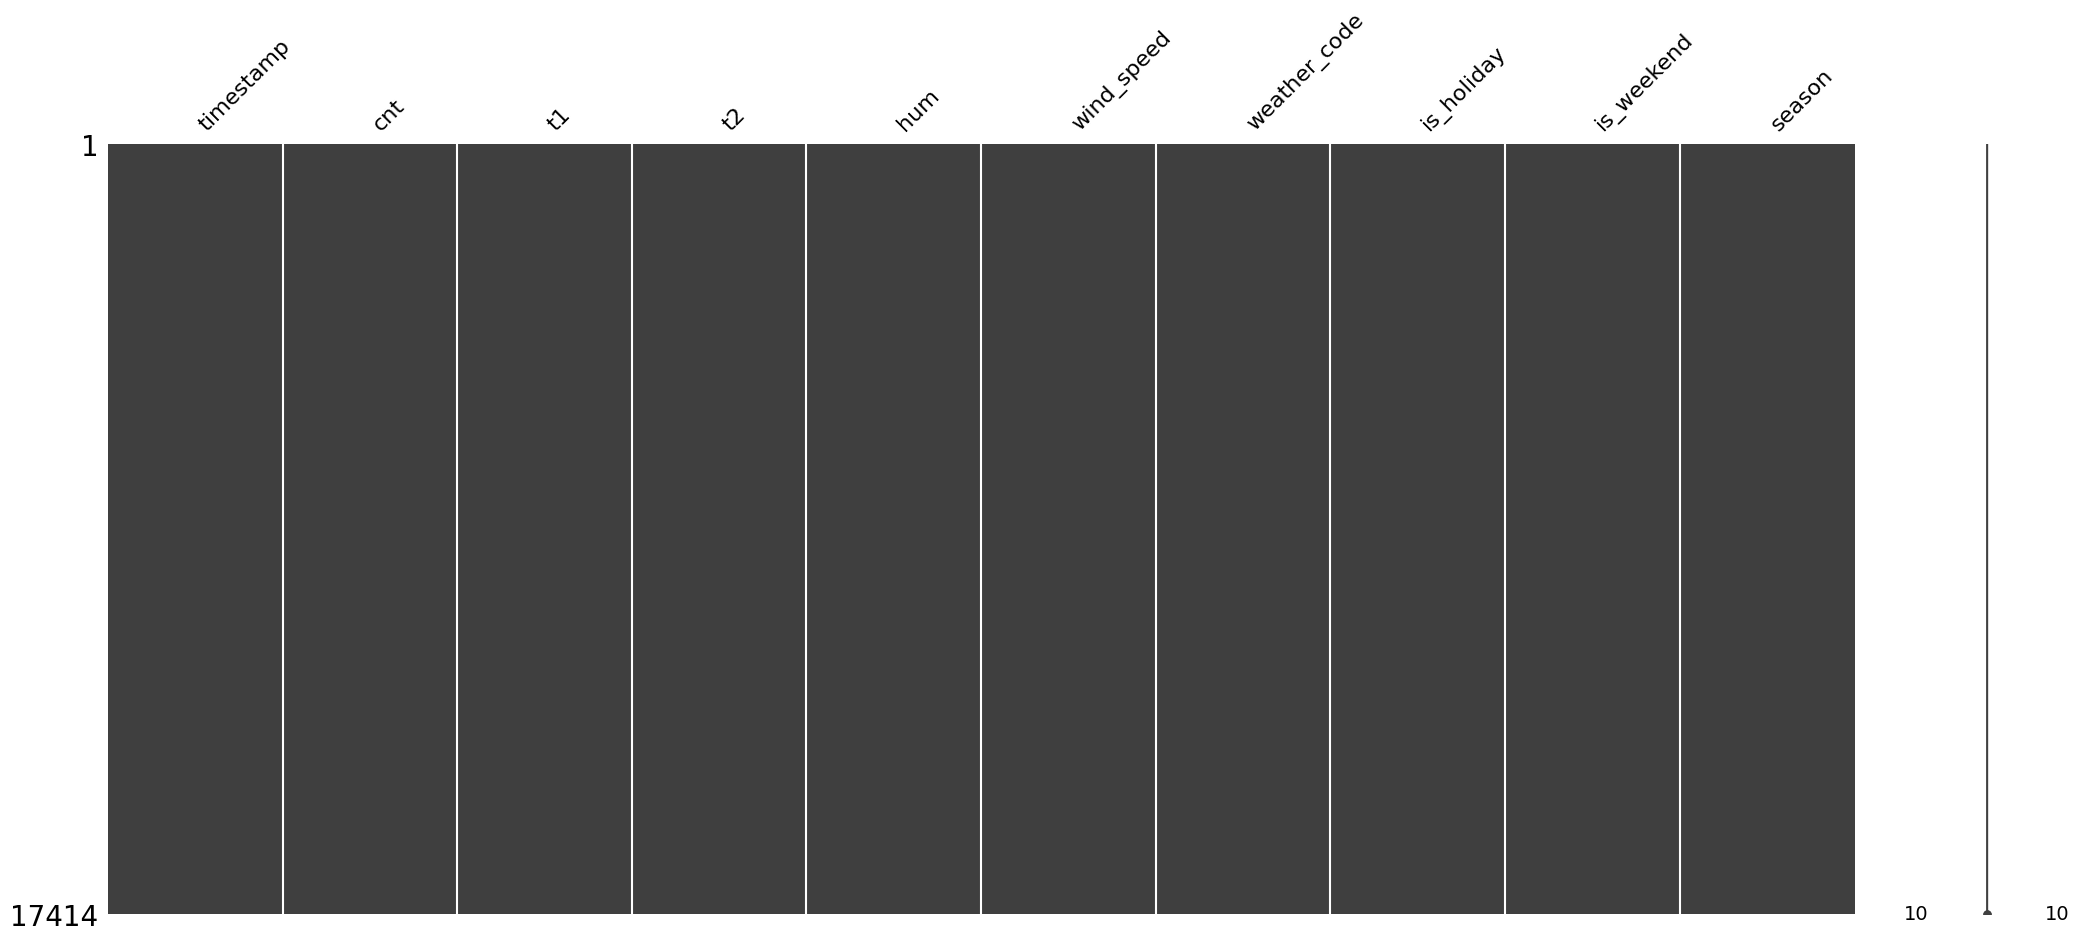

In [13]:
msno.matrix(df) # 결측치 시각화
plt.show # 결측치 없음

df['year'] = df['timestamp'].dt.year  
df['month'] = df['timestamp'].dt.month  
df['dayofweek'] = df['timestamp'].dt.dayofweek  
df['hour'] = df['timestamp'].dt.hour  

.dt는 pandas가 제공하는 datetime(줄여서 dt) 전용 접근자이다.

**dt란, pandas Series가 datetime64[ns] 타입일 때만 사용할 수 있는 특수한 접근자이다.**

위의 year month dayofweek hour은 👉 pandas가 .dt 아래에 미리 정의해둔 “속성(property)”들이다!  

df['timestamp'].dt.year
    “이 Series 안에 들어 있는 모든 datetime 값들에서 year 속성만 뽑아라” 라는 뜻이다. 

from datetime import datetime

t = datetime(2026, 1, 20, 15, 30)

t.year        # 2026
t.month       # 1
t.weekday()   # 1 (함수)
t.hour        # 15
이러한 형식으로 되어있다.  

    dayofweek의 경우 월요일 = 0 ~ 일요일 = 6으로 범주화 되어있다. 

In [14]:
df['year'] = df['timestamp'].dt.year
df['month'] = df['timestamp'].dt.month
df['dayofweek'] = df['timestamp'].dt.dayofweek
df['hour'] = df['timestamp'].dt.hour
df.head() # timestamp 데이터를 이용해서 새로운 데이터 칼럼을 만들었다. (모델이 학습할 수 있도록 많은 데이터를 추출하는 것이다)

,timestamp,cnt,t1,t2,hum,wind_speed,weather_code,is_holiday,is_weekend,season,year,month,dayofweek,hour
0,2015-01-04 00:00:00,182,3.0,2.0,93.0,6.0,3.0,0.0,1.0,3.0,2015,1,6,0
1,2015-01-04 01:00:00,138,3.0,2.5,93.0,5.0,1.0,0.0,1.0,3.0,2015,1,6,1
2,2015-01-04 02:00:00,134,2.5,2.5,96.5,0.0,1.0,0.0,1.0,3.0,2015,1,6,2
3,2015-01-04 03:00:00,72,2.0,2.0,100.0,0.0,1.0,0.0,1.0,3.0,2015,1,6,3
4,2015-01-04 04:00:00,47,2.0,0.0,93.0,6.5,1.0,0.0,1.0,3.0,2015,1,6,4


In [15]:
# EDA를 시작해보자

In [16]:
df['dayofweek'].value_counts() # 월 ~ 일이 들어가 있다. 

dayofweek
0    2508
6    2505
1    2505
3    2492
2    2489
5    2465
4    2450
Name: count, dtype: int64

In [17]:
#seaborn을 통해 시각화해보자

<Axes: xlabel='year', ylabel='cnt'>

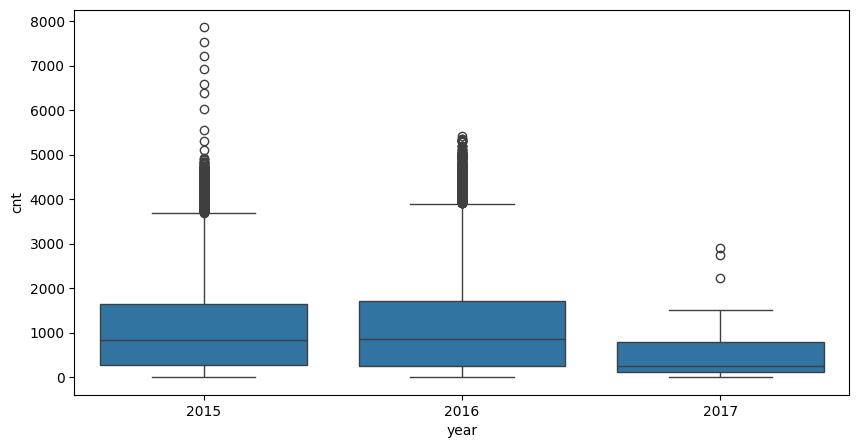

In [18]:
a,b = plt.subplots(1,1, figsize = (10,5))
sns.boxplot(x='year', y='cnt', data=df)

<Axes: xlabel='month', ylabel='cnt'>

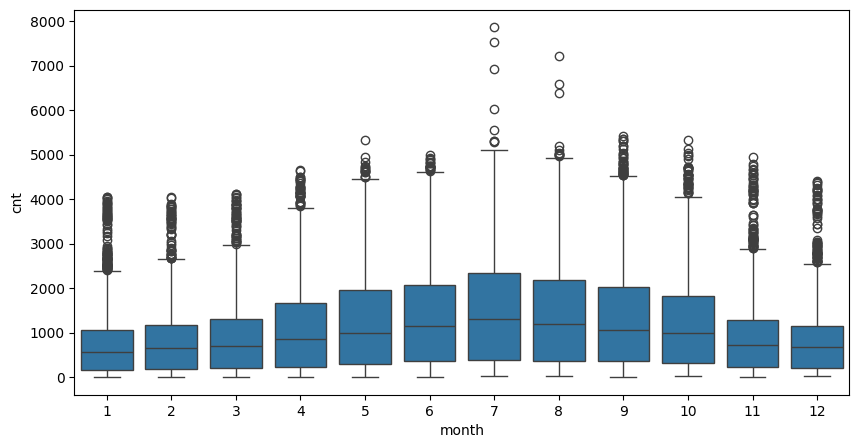

In [19]:
a,b = plt.subplots(1,1, figsize = (10,5))
sns.boxplot(x='month', y='cnt', data=df)

<Axes: xlabel='dayofweek', ylabel='cnt'>

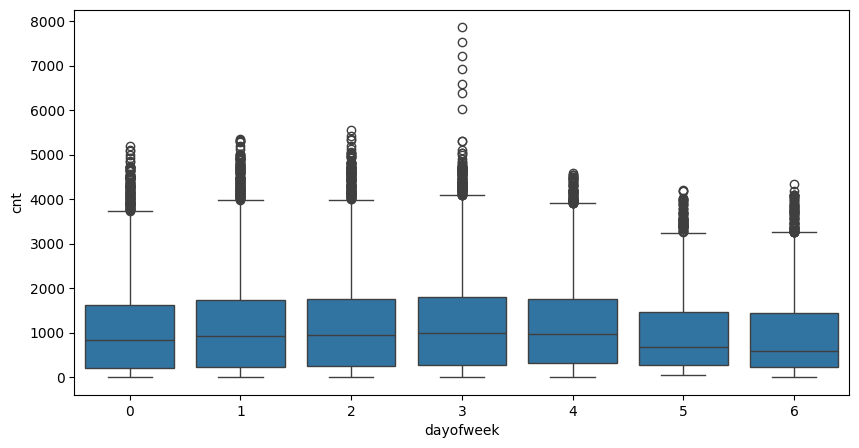

In [20]:
a,b = plt.subplots(1,1, figsize = (10,5))
sns.boxplot(x='dayofweek', y='cnt', data=df)
# 오히려 평일에 자전거 공유가 많더라

<Axes: xlabel='hour', ylabel='cnt'>

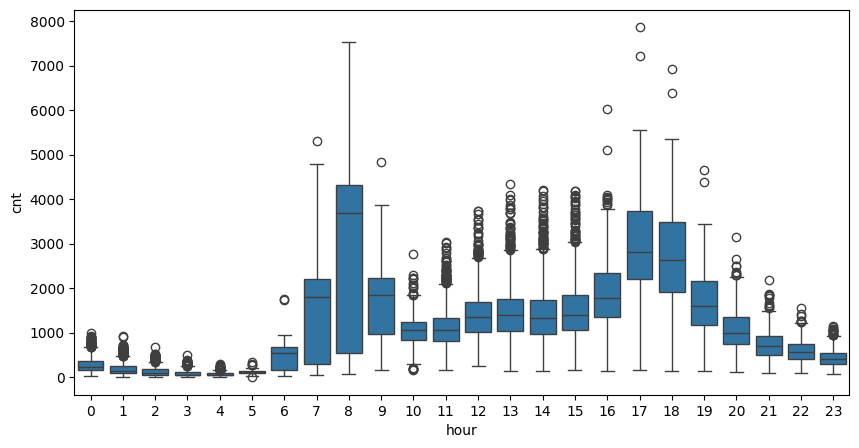

In [21]:
a,b = plt.subplots(1,1, figsize = (10,5))
sns.boxplot(x='hour', y='cnt', data=df)
# 출퇴근 시간에 많이 이용을 하는 것 같다!

In [22]:
# 그래프 만드는 함수 만들기
def plot_bar(data, feature):
    fig = plt.figure(figsize = (12,3))
    sns.barplot(x = feature, y = 'cnt', data = data, palette= 'Set3',orient = 'v')

/tmp/ipykernel_55/584979824.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x = feature, y = 'cnt', data = data, palette= 'Set3',orient = 'v')


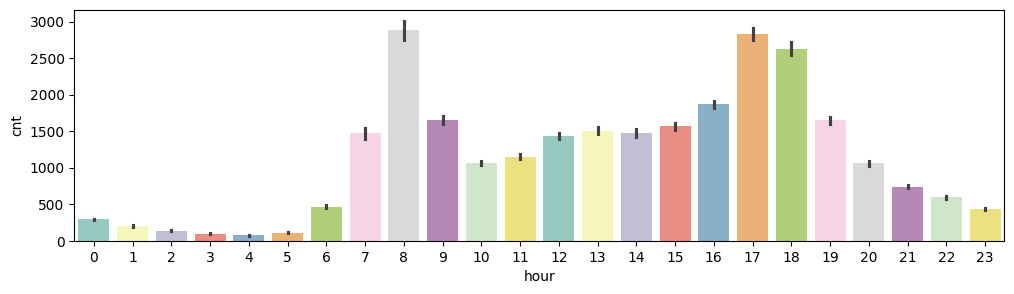

In [23]:
plot_bar(data=df, feature='hour') # 함수로 만들어서 바로 그래프를 그릴 수 있다. 

/tmp/ipykernel_55/584979824.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x = feature, y = 'cnt', data = data, palette= 'Set3',orient = 'v')


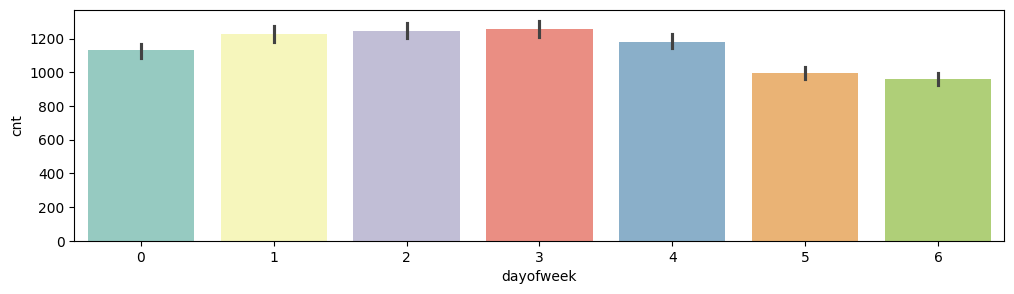

In [24]:
plot_bar(data= df, feature = 'dayofweek')

In [25]:
# 이상치를 제거해보자

In [26]:
# 아웃라이어 제거(시그마 이상치 제거)

def is_outliers(s):
    lower_limit = s.mean() - (s.std()*3)
    upper_limit = s.mean() + (s.std()*3)
    return ~s.between(lower_limit, upper_limit) # 상한 값과 하한 값의 사이의 값을 보여줘!

# 데이터를 정규분포라고 보았을 때 양극단에 있는 이상치를 제거하는 방법이다. IQR 방법, knn 머신러닝을 이용한 이상치 제거 방법도 있다. 

In [27]:
df[~df.groupby(by = 'hour')['cnt'].transform(is_outliers)] # 데이터를 hour 기준으로 나누고 각 시간대 그룹에서 cnt마 선택
# 이 코드는 각 시간대별 cnt 분포에서 평균 +_ 3표준편차르 ㄹ벗어난 관측치를 제거하는 코드이다. 
# 즉, 전체 데이터 기준 이상치가 아니라, 시간대별 조건부 이상치 제거이다. 각 시간대 별 분포 맥락 안에서 이상치를 정의하고 제거한다. 

,timestamp,cnt,t1,t2,hum,wind_speed,weather_code,is_holiday,is_weekend,season,year,month,dayofweek,hour
0,2015-01-04 00:00:00,182,3.0,2.0,93.0,6.0,3.0,0.0,1.0,3.0,2015,1,6,0
1,2015-01-04 01:00:00,138,3.0,2.5,93.0,5.0,1.0,0.0,1.0,3.0,2015,1,6,1
2,2015-01-04 02:00:00,134,2.5,2.5,96.5,0.0,1.0,0.0,1.0,3.0,2015,1,6,2
3,2015-01-04 03:00:00,72,2.0,2.0,100.0,0.0,1.0,0.0,1.0,3.0,2015,1,6,3
4,2015-01-04 04:00:00,47,2.0,0.0,93.0,6.5,1.0,0.0,1.0,3.0,2015,1,6,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
17409,2017-01-03 19:00:00,1042,5.0,1.0,81.0,19.0,3.0,0.0,0.0,3.0,2017,1,1,19
17410,2017-01-03 20:00:00,541,5.0,1.0,81.0,21.0,4.0,0.0,0.0,3.0,2017,1,1,20
17411,2017-01-03 21:00:00,337,5.5,1.5,78.5,24.0,4.0,0.0,0.0,3.0,2017,1,1,21
17412,2017-01-03 22:00:00,224,5.5,1.5,76.0,23.0,4.0,0.0,0.0,3.0,2017,1,1,22


In [28]:
df_out = df[~df.groupby(by = 'hour')['cnt'].transform(is_outliers)]
df_out

,timestamp,cnt,t1,t2,hum,wind_speed,weather_code,is_holiday,is_weekend,season,year,month,dayofweek,hour
0,2015-01-04 00:00:00,182,3.0,2.0,93.0,6.0,3.0,0.0,1.0,3.0,2015,1,6,0
1,2015-01-04 01:00:00,138,3.0,2.5,93.0,5.0,1.0,0.0,1.0,3.0,2015,1,6,1
2,2015-01-04 02:00:00,134,2.5,2.5,96.5,0.0,1.0,0.0,1.0,3.0,2015,1,6,2
3,2015-01-04 03:00:00,72,2.0,2.0,100.0,0.0,1.0,0.0,1.0,3.0,2015,1,6,3
4,2015-01-04 04:00:00,47,2.0,0.0,93.0,6.5,1.0,0.0,1.0,3.0,2015,1,6,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
17409,2017-01-03 19:00:00,1042,5.0,1.0,81.0,19.0,3.0,0.0,0.0,3.0,2017,1,1,19
17410,2017-01-03 20:00:00,541,5.0,1.0,81.0,21.0,4.0,0.0,0.0,3.0,2017,1,1,20
17411,2017-01-03 21:00:00,337,5.5,1.5,78.5,24.0,4.0,0.0,0.0,3.0,2017,1,1,21
17412,2017-01-03 22:00:00,224,5.5,1.5,76.0,23.0,4.0,0.0,0.0,3.0,2017,1,1,22


In [29]:
print('이상치 제거하기 전 행 열:', df.shape)
print('이상치 제거한 후 행 열:', df_out.shape)

이상치 제거하기 전 행 열: (17414, 14)
이상치 제거한 후 행 열: (17265, 14)


In [30]:
df_out.dtypes 

timestamp       datetime64[ns]
cnt                      int64
t1                     float64
t2                     float64
hum                    float64
wind_speed             float64
weather_code           float64
is_holiday             float64
is_weekend             float64
season                 float64
year                     int32
month                    int32
dayofweek                int32
hour                     int32
dtype: object

In [31]:
# 기계가 학습하기 위해서 카테고리형으로 변경을 해주자

In [32]:
df_out['weather_code'] = df_out['weather_code'].astype('category')
df_out['season'] = df_out['season'].astype('category')

/tmp/ipykernel_55/1132137381.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_out['weather_code'] = df_out['weather_code'].astype('category')
/tmp/ipykernel_55/1132137381.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_out['season'] = df_out['season'].astype('category')


In [33]:
df['hour'] = df['hour'].astype('category') # 시간이지만, 23은 0에 가까운 시간인데 숫자로 보면 멀어진다. 그러므로 카테고리 변수로 다루는게 일반적으로 안전하다. 
df['year'] = df['year'].astype('category')
df['month'] = df['month'].astype('category')

In [34]:
df_out.dtypes 

timestamp       datetime64[ns]
cnt                      int64
t1                     float64
t2                     float64
hum                    float64
wind_speed             float64
weather_code          category
is_holiday             float64
is_weekend             float64
season                category
year                     int32
month                    int32
dayofweek                int32
hour                     int32
dtype: object

In [35]:
# 딥러닝에서는 더미처리를 반드시 처리해줘야 한다. 
# 대부분의 모델은 카테고리 변수를 직접 먹지 못한다. 
# 카테고리 변수는 ‘의미 해석 단계’이고, 더미변수는 ‘모델이 바로 먹을 수 있게 숫자로 변환한 단계’다.
# 카테고리는 의미 구분이고, 더미처리는 모델이 계산할 수 있도록 하는 것이다. (즉, 더미는 수치화이다)
    # category → “이건 범주야”
    # dummy → “범주를 숫자로 바꿔서 모델에 넣을게”

In [36]:
df_out = pd.get_dummies(df_out, columns=['weather_code','season','year','month','hour'])
df_out.head()

,timestamp,cnt,t1,t2,hum,wind_speed,is_holiday,is_weekend,dayofweek,weather_code_1.0,...,hour_14,hour_15,hour_16,hour_17,hour_18,hour_19,hour_20,hour_21,hour_22,hour_23
0,2015-01-04 00:00:00,182,3.0,2.0,93.0,6.0,0.0,1.0,6,False,...,False,False,False,False,False,False,False,False,False,False
1,2015-01-04 01:00:00,138,3.0,2.5,93.0,5.0,0.0,1.0,6,True,...,False,False,False,False,False,False,False,False,False,False
2,2015-01-04 02:00:00,134,2.5,2.5,96.5,0.0,0.0,1.0,6,True,...,False,False,False,False,False,False,False,False,False,False
3,2015-01-04 03:00:00,72,2.0,2.0,100.0,0.0,0.0,1.0,6,True,...,False,False,False,False,False,False,False,False,False,False
4,2015-01-04 04:00:00,47,2.0,0.0,93.0,6.5,0.0,1.0,6,True,...,False,False,False,False,False,False,False,False,False,False


In [37]:
df_out.info() # 딥러닝 할 때 컴퓨터가 학습하는 데에 도움이 된다. 

<class 'pandas.core.frame.DataFrame'>
Index: 17265 entries, 0 to 17413
Data columns (total 59 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   timestamp          17265 non-null  datetime64[ns]
 1   cnt                17265 non-null  int64         
 2   t1                 17265 non-null  float64       
 3   t2                 17265 non-null  float64       
 4   hum                17265 non-null  float64       
 5   wind_speed         17265 non-null  float64       
 6   is_holiday         17265 non-null  float64       
 7   is_weekend         17265 non-null  float64       
 8   dayofweek          17265 non-null  int32         
 9   weather_code_1.0   17265 non-null  bool          
 10  weather_code_2.0   17265 non-null  bool          
 11  weather_code_3.0   17265 non-null  bool          
 12  weather_code_4.0   17265 non-null  bool          
 13  weather_code_7.0   17265 non-null  bool          
 14  weather_cod

In [38]:
# 우리는 시간대별 자전거 이용객을 예측하고자 한다.
# 그러므로 종속변수는 cnt 이고 나머지는 모두 독립변수로 보면 된다 .

In [39]:
df_y = df_out['cnt']
df_x = df_out.drop(['timestamp','cnt'],axis=1)

In [86]:
df_y

0         182
1         138
2         134
3          72
4          47
         ... 
17409    1042
17410     541
17411     337
17412     224
17413     139
Name: cnt, Length: 17265, dtype: int64

In [90]:
(df_y == 1885).any()
df_y[df_y == 1885].head()
print(df_y.describe())
print(df_y.max())

count    17265.000000
mean      1133.286012
std       1072.364542
min          0.000000
25%        252.000000
50%        840.000000
75%       1654.000000
max       7531.000000
Name: cnt, dtype: float64
7531


In [40]:
df_x.head()

,t1,t2,hum,wind_speed,is_holiday,is_weekend,dayofweek,weather_code_1.0,weather_code_2.0,weather_code_3.0,...,hour_14,hour_15,hour_16,hour_17,hour_18,hour_19,hour_20,hour_21,hour_22,hour_23
0,3.0,2.0,93.0,6.0,0.0,1.0,6,False,False,True,...,False,False,False,False,False,False,False,False,False,False
1,3.0,2.5,93.0,5.0,0.0,1.0,6,True,False,False,...,False,False,False,False,False,False,False,False,False,False
2,2.5,2.5,96.5,0.0,0.0,1.0,6,True,False,False,...,False,False,False,False,False,False,False,False,False,False
3,2.0,2.0,100.0,0.0,0.0,1.0,6,True,False,False,...,False,False,False,False,False,False,False,False,False,False
4,2.0,0.0,93.0,6.5,0.0,1.0,6,True,False,False,...,False,False,False,False,False,False,False,False,False,False


In [41]:
df_y.head()

0    182
1    138
2    134
3     72
4     47
Name: cnt, dtype: int64

In [42]:
# 모형 돌리기 전 훈련용과 테스트 데이터를 나누는 작업

In [43]:
# 훈련용, 테스트 데이터 분리 

from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(df_x, df_y, random_state=75, test_size=0.3, shuffle = False) # 시계열 데이터이기 때문에 셔플을 False로 해줘야 한다.

In [44]:
print(x_train.shape)
print(y_train.shape)
print(x_test.shape)
print(y_test.shape)

(12085, 57)
(12085,)
(5180, 57)
(5180,)


In [45]:
print(y_train.shape) # 1차원 자료구조 즉, 시리즈이기 때문이다. 열은 존재하지 않는다. 시리즈에는 열 개념이 없는 1차원 데이터 구조이다. 
# 시리즈는 행 라벨(인덱스)와 값만 존재하고 칼럼이 없다. (칼럼명도 당연히 없다)

(12085,)


In [46]:
# 딥러닝

In [47]:
import keras

2026-01-20 11:35:54.938334: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1768908955.246537      55 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1768908955.341486      55 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1768908956.108687      55 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1768908956.108739      55 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1768908956.108742      55 computation_placer.cc:177] computation placer alr

In [48]:
from keras.models import Sequential
from keras.layers import Dense
from keras.callbacks import EarlyStopping

In [49]:
# 층을 쌓아서 하는 딥러닝을 해보자. EarlyStopping 옵션을 넣어서 딥러닝 학습의 과적합을 방지한다

In [50]:
model = Sequential()
model.add(Dense(units=160, activation='relu',input_dim=57))
model.add(Dense(units=60, activation = 'relu'))
model.add(Dense(units=20, activation = 'relu'))
model.add(Dense(units=1, activation = 'linear'))

/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
2026-01-20 11:36:14.949615: E external/local_xla/xla/stream_executor/cuda/cuda_platform.cc:51] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: UNKNOWN ERROR (303)


In [51]:
model.summary() # 층이 나온다. 

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 160)            │         9,280 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 60)             │         9,660 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 20)             │         1,220 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 1)              │            21 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 20,181 (78.83 KB)

 Trainable params: 20,181 (78.83 KB)

 Non-trainable params: 0 (0.00 B)

In [52]:
model.compile(loss='mae', optimizer='adam',metrics=['mae'])
early_stopping = EarlyStopping(monitor = 'loss', patience = 5, mode='min')
history = model.fit(x_train, y_train, epochs=50, batch_size=1, validation_split = 0.1, callbacks=[early_stopping])

Epoch 1/50
10876/10876 ━━━━━━━━━━━━━━━━━━━━ 28s 2ms/step - loss: 633.1857 - mae: 633.1857 - val_loss: 454.3751 - val_mae: 454.3751
Epoch 2/50
10876/10876 ━━━━━━━━━━━━━━━━━━━━ 26s 2ms/step - loss: 351.7929 - mae: 351.7929 - val_loss: 412.9822 - val_mae: 412.9822
Epoch 3/50
10876/10876 ━━━━━━━━━━━━━━━━━━━━ 27s 2ms/step - loss: 266.1420 - mae: 266.1420 - val_loss: 239.3588 - val_mae: 239.3588
Epoch 4/50
10876/10876 ━━━━━━━━━━━━━━━━━━━━ 25s 2ms/step - loss: 233.0380 - mae: 233.0380 - val_loss: 255.0422 - val_mae: 255.0422
Epoch 5/50
10876/10876 ━━━━━━━━━━━━━━━━━━━━ 24s 2ms/step - loss: 199.9669 - mae: 199.9669 - val_loss: 205.7750 - val_mae: 205.7750
Epoch 6/50
10876/10876 ━━━━━━━━━━━━━━━━━━━━ 25s 2ms/step - loss: 184.0591 - mae: 184.0591 - val_loss: 174.8573 - val_mae: 174.8573
Epoch 7/50
10876/10876 ━━━━━━━━━━━━━━━━━━━━ 24s 2ms/step - loss: 167.4317 - mae: 167.4317 - val_loss: 223.6726 - val_mae: 223.6726
Epoch 8/50
10876/10876 ━━━━━━━━━━━━━━━━━━━━ 24s 2ms/step - loss: 156.5611 - mae: 15

In [53]:
# 시각화

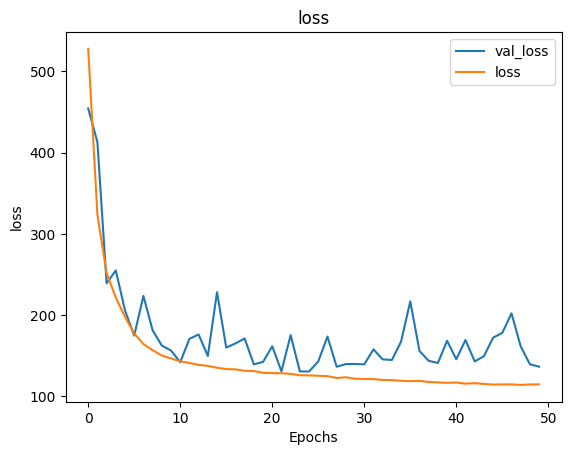

In [55]:
plt.plot(history.history['val_loss'])
plt.plot(history.history['loss'])
plt.title('loss')
plt.xlabel('Epochs')
plt.ylabel('loss')
plt.legend(['val_loss','loss'])

In [56]:
# 딥러닝을 이용해서 똑똑한 모형을 만들었다.

In [58]:
from sklearn.metrics import mean_squared_error

In [61]:
y_predict = model.predict(x_test) # 테스트 데이터로 예측해보자

162/162 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


In [63]:
def RMSE(y_test, y_predict):
    return np.sqrt(mean_squared_error(y_test, y_predict))
print('RMSE', RMSE(y_test, y_predict))

# RMSE가 낮을 수록 좋다. 258

RMSE 258.4223620113012


In [64]:
# 랜덤 포레스트로 머신러닝 모델을 만들자

In [66]:
from sklearn.ensemble import RandomForestRegressor
rf = RandomForestRegressor(n_estimators = 100, random_state=16)
rf.fit(x_train, y_train)
rf_result = rf.predict(x_test)
print('RMSE:', RMSE(y_test, rf_result)) # 예측값과 실제값 비교

# RMSE 303
# 랜덤포레스트가 딥러닝 보다는 성능이 떨어지는 것을 확인(이번 데이터에서는)

RMSE: 303.6417775662534


In [67]:
from xgboost import XGBRegressor # 분류 예측이면 classfiy겠지만, 우리의 예측은 이용객 수 예측이기 때문에 regressor을 사용한다

In [69]:
xgb = XGBRegressor(n_estimators = 100, ranom_state = 16)
xgb.fit(x_train, y_train)
xgb_result = xgb.predict(x_test)
print('RMSE',RMSE(y_test, xgb_result))

# RMSE 320 
# 랜덤포레스트보다 성능이 떨어진다. 

/usr/local/lib/python3.12/dist-packages/xgboost/training.py:199: UserWarning: [12:12:13] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "ranom_state" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


RMSE 320.144193587046


머신러닝은 파라미터에 영향을 많이 받기 때문에 최적의 파라미터 설정을 많이 해봐야한다.

In [71]:
from lightgbm import LGBMRegressor
lgb = LGBMRegressor(n_estimators = 100, randon_state=16)
lgb.fit(x_train, y_train)
lgb_result = lgb.predict(x_test)
print('RMSE:', RMSE(y_test, lgb_result))

# RMSE 323 나옴. 성능이 더 안좋아짐. 

[LightGBM] [Warning] Unknown parameter: randon_state
[LightGBM] [Warning] Unknown parameter: randon_state
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003048 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 451
[LightGBM] [Info] Number of data points in the train set: 12085, number of used features: 55
[LightGBM] [Info] Start training from score 1077.863798
[LightGBM] [Warning] Unknown parameter: randon_state
RMSE: 323.2746495922864


In [ ]:
# 각 모형별로 어떤 차이가 있는 지 살펴보자. 

In [76]:
xgb = pd.DataFrame(xgb_result)
rf = pd.DataFrame(rf_result)
dnn = pd.DataFrame(y_predict)
lgb = pd.DataFrame(lgb_result)
compare = pd.DataFrame(y_test).reset_index(drop=True)

In [77]:
compare['xgb'] = xgb
compare['rf'] = rf
compare['dnn'] = dnn
compare['lgb'] = lgb
compare.head()
# 각 시간대별 자전거 이용객수의 실제 값이 있고 좌측에 예측값들이 있다. 

,cnt,xgb,rf,dnn,lgb
0,1885,1763.592285,1700.24,2135.717041,1830.345197
1,2175,1931.741821,1803.82,2451.184570,2133.296789
2,2485,2800.010742,2191.37,2665.643311,2590.899050
3,2882,2865.234619,2206.67,2597.332275,2613.783086
4,2965,2500.403564,2276.35,2566.707031,2306.341169


/tmp/ipykernel_55/1827850120.py:1: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(compare['cnt'], shade=True, color = 'r')
/tmp/ipykernel_55/1827850120.py:2: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(compare['xgb'], shade=True, color = 'b')
/tmp/ipykernel_55/1827850120.py:3: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(compare['rf'], shade=True, color = 'y')
/tmp/ipykernel_55/1827850120.py:4: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(compare['dnn'], shade=True, color = 'g')
/tmp/ipykernel_55

<Axes: xlabel='cnt', ylabel='Density'>

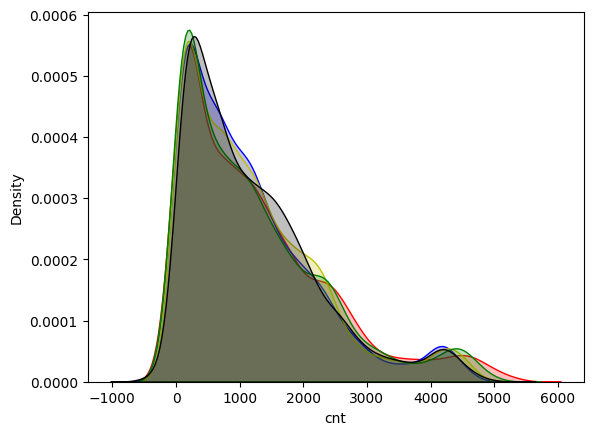

In [84]:
sns.kdeplot(compare['cnt'], shade=True, color = 'r')
sns.kdeplot(compare['xgb'], shade=True, color = 'b')
sns.kdeplot(compare['rf'], shade=True, color = 'y')
sns.kdeplot(compare['dnn'], shade=True, color = 'g')
sns.kdeplot(compare['lgb'], shade=True, color = 'k')

In [85]:
compare

,cnt,xgb,rf,dnn,lgb
0,1885,1763.592285,1700.24,2135.717041,1830.345197
1,2175,1931.741821,1803.82,2451.184570,2133.296789
2,2485,2800.010742,2191.37,2665.643311,2590.899050
3,2882,2865.234619,2206.67,2597.332275,2613.783086
4,2965,2500.403564,2276.35,2566.707031,2306.341169
...,...,...,...,...,...
5175,1042,1339.235718,1410.17,1171.710693,1175.209838
5176,541,684.058350,816.00,642.771912,693.744776
5177,337,598.180298,589.38,483.360565,563.171451
5178,224,431.340668,414.02,337.646149,478.945187


In [91]:
df_y.tail() # d여기 보면 마지막 139, 224, 337..을 모델이 어떻게 예측했는 지를 확인할 수 있다!

17409    1042
17410     541
17411     337
17412     224
17413     139
Name: cnt, dtype: int64

시계열 데이터에서 shuffle=False를 쓰는 이유는
“미래 데이터를 이용해 과거를 예측하는 사고(데이터 누수)”를 막기 위해서다.    
shuffle=True를 하면 무슨 일이 벌어질까?
    2019년 데이터로 train을 하고 2015년 데이터로 test를 하게 된다. 이렇게 시간이 뒤섞이면, 모델이 미래 정보를 보고 과거를 예측하는 상황이 생긴다(추라고 계절이 섞이는 문제도 있음)

그렇기 때문에 시계열 데이터에서는 앞 70% 학습 뒤 30%을 테스트로 시간의 흐름을 보존하여 과거로 미래를 예측하는 구조가 올바르다. 

